In [311]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [312]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               746 non-null    object 
 1   SeasonNumber       746 non-null    int64  
 2   SeasonVersion      746 non-null    int64  
 3   Player             746 non-null    object 
 4   MatchId            746 non-null    object 
 5   Map                746 non-null    object 
 6   Category           746 non-null    object 
 7   Playlist           746 non-null    object 
 8   Input              746 non-null    object 
 9   Queue              746 non-null    object 
 10  PreCsr             746 non-null    int64  
 11  PostCsr            746 non-null    int64  
 12  Rank               746 non-null    int64  
 13  WasAtStart         746 non-null    int64  
 14  WasAtEnd           746 non-null    int64  
 15  WasInProgressJoin  746 non-null    int64  
 16  Mmr                2 non-n

In [313]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - (df['ExpectedKills'] / df['ExpectedDeaths'])
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 140 to 745
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Outcome         502 non-null    int64  
 1   Accuracy        502 non-null    float64
 2   DamageDone      502 non-null    int64  
 3   DamageTaken     502 non-null    int64  
 4   KD              502 non-null    float64
 5   KDA             502 non-null    float64
 6   Kills           502 non-null    int64  
 7   Deaths          502 non-null    int64  
 8   Assists         502 non-null    int64  
 9   MaxSpree        502 non-null    int64  
 10  ExpectedKills   502 non-null    float64
 11  ExpectedDeaths  502 non-null    float64
 12  Score           502 non-null    int64  
 13  Medals          502 non-null    int64  
 14  LengthMinutes   502 non-null    float64
 15  DamageRatio     502 non-null    float64
 16  Damage/Kill     502 non-null    float64
 17  Kills/10Min     502 non-null    f

In [314]:
def cnt(df, col):
    count = df[col].count()
    return count
def sm(df, col):
    sum = df[col].sum()
    return sum
def avg(df, col, val=None):
    avg = round(sm(df, col) / cnt(df, col),val)
    return avg


In [315]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.444224
DmgT/10Min        0.359225
Deaths            0.316293
KD                0.310405
KDA               0.281475
ExcessDeaths      0.276241
DamageRatio       0.262111
ExcessKD          0.246587
DamageTaken       0.238170
ExpectedDeaths    0.195900
Damage/Kill       0.187969
Assists/10Min     0.168545
Kills/10Min       0.139599
MaxSpree          0.128911
LengthMinutes     0.120923
DamageDone        0.087841
Accuracy          0.063873
Assists           0.047590
Score             0.042197
Dmg/10Min         0.026178
Shots/10Min       0.023698
Medals            0.023558
ExpectedKills     0.015098
GrenadePct        0.013798
MeleePct          0.012515
Kills             0.011918
HSPct             0.009375
BodyPct           0.007766
PowerPct          0.005558
ExcessKills       0.002294
Name: Outcome, dtype: float64


In [316]:
# dfRR.hist(bins=15, figsize=(16, 12))
# plt.tight_layout()
# plt.show()

In [317]:
dfRR.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Outcome,502.0,0.541833,0.498744,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,502.0,51.435817,5.122064,36.800000,48.295000,51.485000,54.417500,80.560000
DamageDone,502.0,5224.065737,1794.616045,667.000000,3935.250000,4955.500000,6420.750000,12673.000000
DamageTaken,502.0,4439.760956,1498.309401,644.000000,3455.500000,4254.500000,5354.250000,9962.000000
KD,502.0,1.279940,0.769795,0.270000,0.860000,1.130000,1.460000,10.000000
KDA,502.0,4.666016,5.636439,-9.660000,0.660000,4.660000,8.000000,31.000000
Kills,502.0,14.679283,6.301374,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,502.0,12.822709,5.045743,0.000000,10.000000,12.000000,16.000000,32.000000
Assists,502.0,8.434263,4.194696,1.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,502.0,3.972112,1.570442,1.000000,3.000000,4.000000,5.000000,10.000000


In [318]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [319]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (502, 30)
Y Shape: (502,)


In [339]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=2)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
print(X_train.columns)
print(X_train['Kills'].value_counts().sort_values(ascending=False))



X Train Shape: (401, 30)
X Test Shape: (101, 30)
Index(['Accuracy', 'DamageDone', 'DamageTaken', 'KD', 'KDA', 'Kills', 'Deaths',
       'Assists', 'MaxSpree', 'ExpectedKills', 'ExpectedDeaths', 'Score',
       'Medals', 'LengthMinutes', 'DamageRatio', 'Damage/Kill', 'Kills/10Min',
       'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min', 'DmgT/10Min',
       'Shots/10Min', 'ExcessKills', 'ExcessDeaths', 'ExcessKD', 'BodyPct',
       'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'],
      dtype='object')
14    31
15    28
12    28
11    27
13    27
10    24
17    23
19    23
7     22
8     20
18    18
9     15
16    14
22    13
20    13
6     12
21    10
23     9
4      8
28     5
24     5
26     4
30     3
25     3
29     3
27     3
3      2
5      2
1      1
35     1
33     1
31     1
37     1
40     1
Name: Kills, dtype: int64


In [333]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'DamageDone', 'DamageTaken', 'KD', 'KDA', 'Kills',
                                    'Deaths', 'Assists', 'MaxSpree', 'ExpectedKills', 'ExpectedDeaths',
                                    'Score', 'Medals', 'LengthMinutes', 'DamageRatio', 'Damage/Kill',
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths', 'ExcessKD',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)



print(f'X Train Processed Shape: {X_train_preprocessed.shape}')
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Processed Shape: {X_test_preprocessed.shape}')




ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MSE_Histmean = mean_squared_error(y_test,np.full(y_test.shape,np.mean(y_train)))

def ResultsOut(model):
  y_pred = model.predict(X_test_preprocessed)
  # Calculate regression metrics
  acc = model.score(X_test_preprocessed, y_test)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)
  oosr2 = 1-mean_squared_error(y_test,y_pred)/MSE_Histmean
  # Print the metrics with newline characters
  print("Acc: {:.3f}".format(acc))
  print("MAE: {:.2f}".format(mae))
  print("MSE: {:.2f}".format(mse))
  print("RMSE: {:.2f}".format(rmse))
  print("R^2 Score: {:.2f}".format(r2))
  print("OOS R^2 Score: {:.2f}".format(oosr2))
  return ''

def paramResults(mod):
    results_df = pd.DataFrame({'param': mod.cv_results_["params"], 'Accuracy': mod.cv_results_["mean_test_score"]})

    # Splitting the 'param' column into separate columns
    params_df = pd.DataFrame(results_df['param'].to_list())
    params_df.columns = [f"{col}_param" for col in params_df.columns]

    # Concatenating the new columns with the 'Accuracy' column
    results_df = pd.concat([params_df, results_df['Accuracy']], axis=1)

    # Displaying the updated DataFrame
    print(results_df)
    return ''

def featImport(mod):
    feat_importances = pd.DataFrame(mod.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))
    plt.show()

## Logistic Regression

In [ ]:
# Unregularized Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train_preprocessed, y_train)

print(f'Unregularized Logistic Regression Accuracy: {logreg.score(X_test_preprocessed, y_test)}')
print(ResultsOut(logreg))

Unregularized Logistic Regression Accuracy: 0.7777777777777778
Acc: 0.778
MAE: 0.22
MSE: 0.22
RMSE: 0.47
R^2 Score: 0.11
OOS R^2 Score: 0.11



## Ridge

In [ ]:
# Ridge
# Need to find best params for param grid

C_grid = [10**-3,10**-2,10**-1,10**0,10**1,10**2]

param_grid={'C':C_grid}
ridge_cv = GridSearchCV(LogisticRegression(penalty='l2',solver='saga'),
                                          param_grid=param_grid,cv=5)
ridge_cv.fit(X_train_preprocessed,y_train)

print(ridge_cv.best_estimator_)
print(f'Ridge Accuracy: {ridge_cv.score(X_test_preprocessed, y_test)}')
ridge_cv.cv_results_
paramResults(ridge_cv)

LogisticRegression(C=1, solver='saga')
Ridge Accuracy: 0.797979797979798
   C_param  Accuracy
0    0.001  0.650633
1    0.010  0.729114
2    0.100  0.754430
3    1.000  0.777215
4   10.000  0.774684
5  100.000  0.774684


''

In [ ]:
ResultsOut(ridge_cv)

Acc: 0.798
MAE: 0.20
MSE: 0.20
RMSE: 0.45
R^2 Score: 0.19
OOS R^2 Score: 0.19


''

## Lasso

In [ ]:
# Lasso

param_grid={'C':C_grid}
lasso_cv = GridSearchCV(LogisticRegression(penalty='l1',solver='saga'),
                                          param_grid=param_grid,cv=5)
lasso_cv.fit(X_train_preprocessed,y_train)

print(lasso_cv.best_estimator_)
print(f'Lasso Accuracy: {lasso_cv.score(X_test_preprocessed, y_test)}')
lasso_cv.cv_results_
paramResults(lasso_cv)


LogisticRegression(C=1, penalty='l1', solver='saga')
Lasso Accuracy: 0.8080808080808081
   C_param  Accuracy
0    0.001  0.541772
1    0.010  0.541772
2    0.100  0.718987
3    1.000  0.779747
4   10.000  0.777215
5  100.000  0.774684


''

In [ ]:
ResultsOut(lasso_cv)

Acc: 0.808
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.23
OOS R^2 Score: 0.23


''

## ElasticNet

In [ ]:
# ElasticNet

param_grid2={'C':C_grid,'l1_ratio':[.25, .5, .75]}

elastic_cv = GridSearchCV(LogisticRegression(penalty='elasticnet',solver='saga'),
                                            param_grid=param_grid2,cv=5)
elastic_cv.fit(X_train_preprocessed,y_train)

print(elastic_cv.best_estimator_)
print(f'ElasticNet Accuracy: {elastic_cv.score(X_test_preprocessed, y_test)}')
elastic_cv.cv_results_
paramResults(elastic_cv)

LogisticRegression(C=1, l1_ratio=0.75, penalty='elasticnet', solver='saga')
ElasticNet Accuracy: 0.8080808080808081
    C_param  l1_ratio_param  Accuracy
0     0.001            0.25  0.541772
1     0.001            0.50  0.524051
2     0.001            0.75  0.541772
3     0.010            0.25  0.701266
4     0.010            0.50  0.645570
5     0.010            0.75  0.541772
6     0.100            0.25  0.767089
7     0.100            0.50  0.746835
8     0.100            0.75  0.731646
9     1.000            0.25  0.782278
10    1.000            0.50  0.782278
11    1.000            0.75  0.784810
12   10.000            0.25  0.774684
13   10.000            0.50  0.777215
14   10.000            0.75  0.777215
15  100.000            0.25  0.772152
16  100.000            0.50  0.772152
17  100.000            0.75  0.774684


''

In [ ]:
ResultsOut(elastic_cv)

Acc: 0.808
MAE: 0.19
MSE: 0.19
RMSE: 0.44
R^2 Score: 0.23
OOS R^2 Score: 0.23


''

## K-Nearest Neighbours

In [ ]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

k_values = list(range(1,50,3))
param_grid = {'n_neighbors': k_values}

knn_cv = GridSearchCV(KNeighborsClassifier(),param_grid,cv=5,n_jobs=-1)
knn_cv.fit(X_train_preprocessed,y_train)

print(knn_cv.best_estimator_)
print(f'K-Nearest Neighbors Accuracy: {knn_cv.score(X_test_preprocessed, y_test)}')
knn_cv.cv_results_
paramResults(knn_cv)

KNeighborsClassifier(n_neighbors=46)
K-Nearest Neighbors Accuracy: 0.6464646464646465
    n_neighbors_param  Accuracy
0                   1  0.602532
1                   4  0.632911
2                   7  0.663291
3                  10  0.658228
4                  13  0.675949
5                  16  0.691139
6                  19  0.678481
7                  22  0.681013
8                  25  0.691139
9                  28  0.688608
10                 31  0.688608
11                 34  0.683544
12                 37  0.681013
13                 40  0.693671
14                 43  0.698734
15                 46  0.706329
16                 49  0.693671


''

In [ ]:
ResultsOut(knn_cv)

Acc: 0.646
MAE: 0.35
MSE: 0.35
RMSE: 0.59
R^2 Score: -0.42
OOS R^2 Score: -0.42


''

## Random Forest

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [100,300,500],'max_depth': [10, 15, 20]}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(random_state=69,max_features='sqrt'),
                                                     cv=5, param_grid=param_grid_rf,n_jobs=-1)
rf_cv.fit(X_train_preprocessed, y_train)

print(rf_cv.best_estimator_)
print(f'Random Forest Accuracy: {rf_cv.score(X_test_preprocessed, y_test)}')
rf_cv.cv_results_
paramResults(rf_cv)

RandomForestClassifier(max_depth=20, n_estimators=500, random_state=69)
Random Forest Accuracy: 0.6666666666666666
   max_depth_param  n_estimators_param  Accuracy
0               10                 100  0.698734
1               10                 300  0.708861
2               10                 500  0.713924
3               15                 100  0.696203
4               15                 300  0.708861
5               15                 500  0.713924
6               20                 100  0.696203
7               20                 300  0.708861
8               20                 500  0.716456


''

In [ ]:
ResultsOut(rf_cv)

Acc: 0.667
MAE: 0.33
MSE: 0.33
RMSE: 0.58
R^2 Score: -0.34
OOS R^2 Score: -0.34


''

<AxesSubplot: >

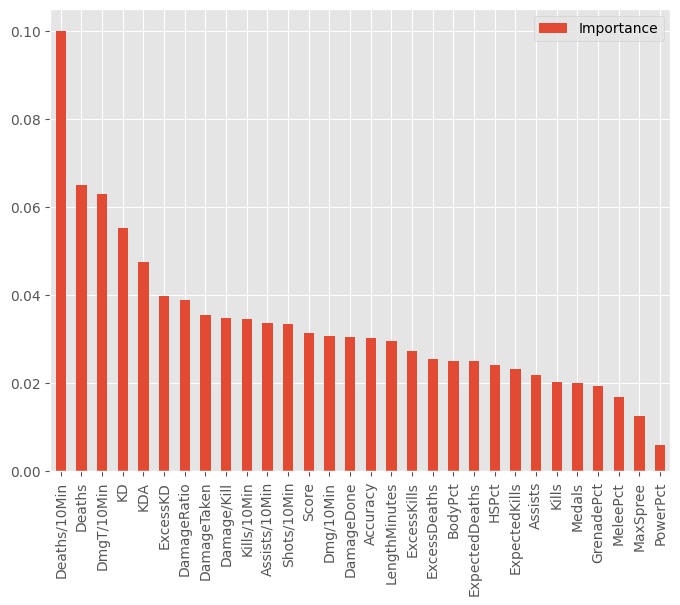

In [ ]:
feat_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Gradient Boosted Trees

In [ ]:
# Gradient Boosted Trees
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gbrt = {'n_estimators': [100,300,500],'learning_rate': [0.01,0.1],'max_depth': [2,4,6], 'subsample': [0.5,1]}
GBRT = GridSearchCV(estimator=GradientBoostingClassifier(random_state=69),
                    cv=5, param_grid=param_grid_gbrt,n_jobs=-1)
GBRT.fit(X_train_preprocessed, y_train)

print(GBRT.best_estimator_)
print(f'Gradient Boosed Trees Accuracy: {GBRT.score(X_test_preprocessed, y_test)}')
GBRT.cv_results_
paramResults(GBRT)

GradientBoostingClassifier(max_depth=4, n_estimators=500, random_state=69,
                           subsample=0.5)
Gradient Boosed Trees Accuracy: 0.6565656565656566
    learning_rate_param  max_depth_param  n_estimators_param  subsample_param  \
0                  0.01                2                 100              0.5   
1                  0.01                2                 100              1.0   
2                  0.01                2                 300              0.5   
3                  0.01                2                 300              1.0   
4                  0.01                2                 500              0.5   
5                  0.01                2                 500              1.0   
6                  0.01                4                 100              0.5   
7                  0.01                4                 100              1.0   
8                  0.01                4                 300              0.5   
9                  0.0

''

In [ ]:
ResultsOut(GBRT)

Acc: 0.657
MAE: 0.34
MSE: 0.34
RMSE: 0.59
R^2 Score: -0.38
OOS R^2 Score: -0.38


''

<AxesSubplot: >

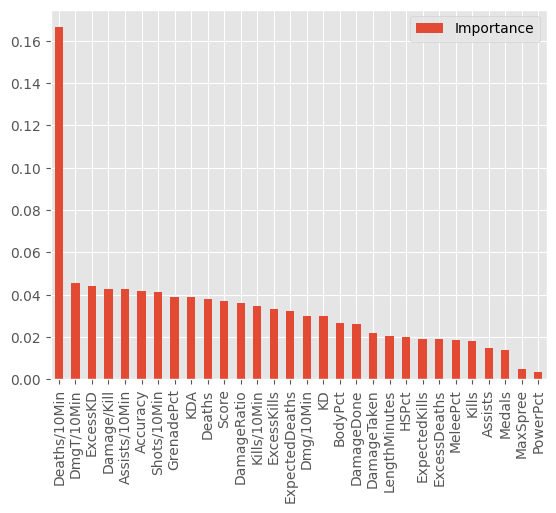

In [ ]:
feat_importances = pd.DataFrame(GBRT.best_estimator_.feature_importances_[:30], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar')

## XGBoost

In [ ]:
from xgboost import XGBClassifier

param_grid_xgb = {'n_estimators': [400,450,475,500],'learning_rate': [0.001,0.01,0.1,0.25],'max_depth': [1,2,3,4,5]}
XGB = GridSearchCV(estimator=XGBClassifier(random_state=69), cv=5, param_grid=param_grid_xgb,n_jobs=-1)
XGB.fit(X_train_preprocessed, y_train)

print(XGB.best_estimator_)
print(f'XGBoost Accuracy: {XGB.score(X_test_preprocessed, y_test)}')
paramResults(XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=69, ...)
XGBoost Accuracy: 0.6666666666666666
    learning_rate_param  max_depth_param  n_estimators_param  Accuracy
0                 0.001                1                 400  0.686076
1                 0.001                1                 450  0.686076
2  

''

In [ ]:
ResultsOut(XGB)

Acc: 0.667
MAE: 0.33
MSE: 0.33
RMSE: 0.58
R^2 Score: -0.34
OOS R^2 Score: -0.34


''

<AxesSubplot: >

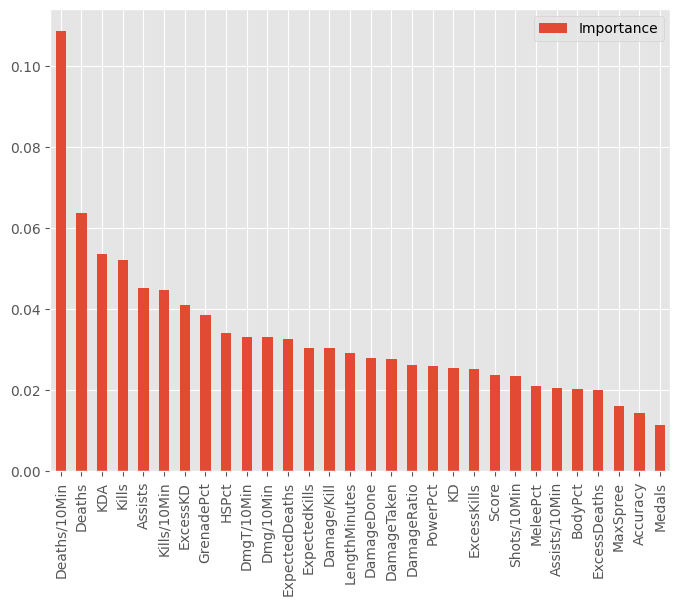

In [ ]:
feat_importances = pd.DataFrame(XGB.best_estimator_.feature_importances_[:32], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

## Neural Net

In [ ]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(random_state=61)
nn.fit(X_train_preprocessed, y_train)

print(nn)
print(f'Neural Net Accuracy: {nn.score(X_test_preprocessed, y_test)}')
from sklearn.metrics import confusion_matrix


# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, nn.predict(X_test_preprocessed))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_nn = pd.DataFrame(nn.coefs_[0].flatten()[:30], index=X_train.columns, columns=["Importance"])
feat_importances_nn = feat_importances_nn.abs().sum(axis=1)
feat_importances_nn = feat_importances_nn / feat_importances_nn.sum()
feat_importances_nn = feat_importances_nn.sort_values(ascending=False)[:32]
feat_importances_nn.plot(kind='bar', figsize=(8,6))


ValueError: Found input variables with inconsistent numbers of samples: [395, 401]

Runtime: 66.93s


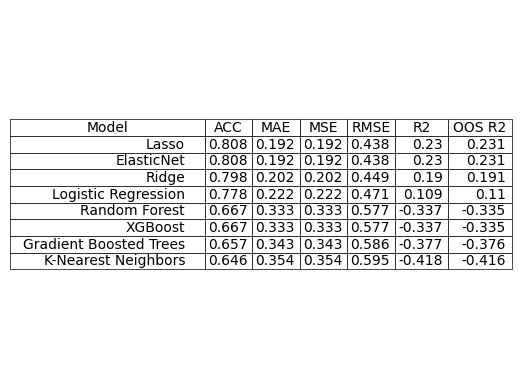

In [ ]:
modelss = [logreg,ridge_cv,lasso_cv,elastic_cv,knn_cv,rf_cv,GBRT,XGB]
model_namess = ['Logistic Regression', 'Ridge', 'Lasso', 'ElasticNet',
              'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosted Trees', 'XGBoost']
def saveResults(models, model_names):
    # Initialize an empty dataframe to store the metrics
    metrics_df = pd.DataFrame(columns=['Model', 'ACC' ,'MAE', 'MSE', 'RMSE', 'R2', 'OOS R2'])
    
    # Loop through each model and calculate the metrics
    for i, model in enumerate(models):
        # Generate predictions on the test set
        y_pred = model.predict(X_test_preprocessed)
        
        # Calculate regression metrics
        acc = round(model.score(X_test_preprocessed, y_test),3)
        mae = round(mean_absolute_error(y_test, y_pred),3)
        mse = round(mean_squared_error(y_test, y_pred),3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False),3)
        r2 = round(r2_score(y_test, y_pred),3)
        oosr2 = round(1-mean_squared_error(y_test,y_pred)/MSE_Histmean,3)
        
        # Add metrics to the dataframe
        metrics_df.loc[i] = [model_names[i],acc, mae, mse, rmse, r2, oosr2]
    
    metrics_df = metrics_df.sort_values('ACC', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots()
    table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
                     cellLoc='right', loc='center')
    table.auto_set_font_size(True)
    table.auto_set_column_width(col=list(range(len(metrics_df.columns))))
    ax.axis('off')
    plt.savefig('ModelResults0210.png', dpi=300, bbox_inches='tight')
    
    return metrics_df

saveResults(modelss,model_namess)
print(f'Runtime: {round(time.perf_counter() - start,2)}s')